In [2]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import numpy as np


In [15]:
save_model = "./models/gan_model.pth"
LOG_INTERVAL = 100
CUDA_DEVICE_NUM = 0
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)


RANDOM_SEED = 42
GENERATOR_LEARNING_RATE = 0.0002
DISCRIMINATOR_LEARNING_RATE = 0.0002

NUM_EPOCHS = 10
BATCH_SIZE = 128

IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 28, 28, 1
LATENT_DIMS = 7


Device: cuda:0


Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


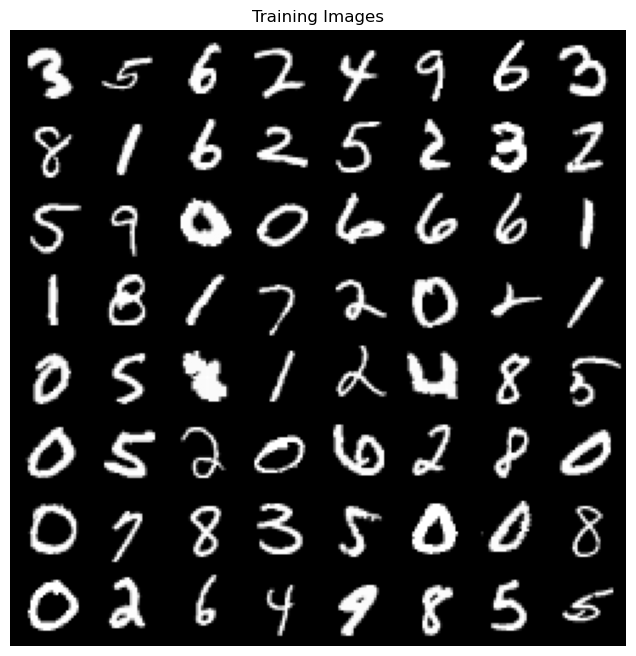

In [4]:

from torchvision import datasets
from torch.utils.data import DataLoader


custom_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])


train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=custom_transforms,
                               download=True)

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE,
                          num_workers=0,
                          shuffle=True)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(images[:64], 
                                         padding=2, normalize=True),
                        (1, 2, 0)))
plt.show()


In [ ]:
import math

class GAN(torch.nn.Module):

    def __init__(self, latent_dim=100, 
                 image_height=28, image_width=28, color_channels=1):
        super().__init__()
        
        self.image_height = image_height
        self.image_width = image_width
        self.color_channels = color_channels
        
        self.generator = nn.Sequential(
            nn.Conv2d(color_channels, color_channels, 4, 2, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(color_channels, color_channels, 4, 2, 1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(color_channels, color_channels, 2, 2, bias=False),
            nn.LazyBatchNorm2d(),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(color_channels, color_channels, 2, 2, 1,bias=False),
            nn.LazyBatchNorm2d(),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(color_channels, color_channels, 2, 2, 1,bias=False),
            nn.LazyBatchNorm2d(),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(color_channels, color_channels, 2, 2, 1,bias=False),
            nn.LazyBatchNorm2d(),
            nn.ReLU(inplace=True),
            nn.Flatten(2),
            nn.LazyLinear(image_height*image_width*color_channels),
            nn.Tanh()
        )
        
        self.discriminator = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(128),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(128, 1),
        )
    
    def generator_forward(self, z):# z has dimension (Batch, 1, Latent_dim, Latent_dim)
        img = self.generator(z)
        img = img.view(z.size(0),
                       self.color_channels,
                       self.image_height,
                       self.image_width)
        return img
    
    def discriminator_forward(self, img):
        logits = self.discriminator(img)
        return logits
    
    

In [18]:
current_iteration = 27

In [19]:

import time
import os
import json

current_iteration += 1
save_dir = f"generated_images/{current_iteration}"
os.makedirs(save_dir, exist_ok=True)

model = GAN(latent_dim=LATENT_DIMS)
model.to(DEVICE)


optim_gen = torch.optim.Adam(model.generator.parameters(),
                             betas=(0.5, 0.999),
                             lr=GENERATOR_LEARNING_RATE)

optim_discr = torch.optim.Adam(model.discriminator.parameters(),
                               betas=(0.5, 0.999),
                               lr=DISCRIMINATOR_LEARNING_RATE)

log_dict = {'train_generator_loss_per_batch': [],
            'train_discriminator_loss_per_batch': [],
            'train_discriminator_real_acc_per_batch': [],
            'train_discriminator_fake_acc_per_batch': [],
            'images_from_noise_per_epoch': []}

loss_fn = nn.functional.binary_cross_entropy_with_logits

fixed_noise = torch.randn(64, 1, IMAGE_WIDTH, IMAGE_HEIGHT, device=DEVICE) # format NCHW
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    model.train()
    for batch_idx, (features, _) in enumerate(train_loader):
        batch_size = features.size(0)
        
        #real images
        real_images = features.to(DEVICE)
        real_labels = torch.ones(batch_size, device=DEVICE)
        
        #fake images 
        noise = torch.randn(batch_size, 1, IMAGE_WIDTH, IMAGE_HEIGHT, device=DEVICE)
        fake_images = model.generator_forward(noise)
        
        fake_labels = torch.zeros(batch_size, device= DEVICE)
        flipped_fake_labels = real_labels
        
        ###  TRAIN DISCRIMINATOR  ##################################################################################
        
        optim_discr.zero_grad()
        discr_pred_real = model.discriminator_forward(real_images).squeeze()
        real_loss = loss_fn(discr_pred_real, real_labels)
        
        discr_pred_fake = model.discriminator_forward(fake_images.detach()).view(-1)
        fake_loss = loss_fn(discr_pred_fake, fake_labels)

        discr_loss = 0.5*(real_loss + fake_loss)
        discr_loss.backward()
        
        optim_discr.step()
        
        optim_gen.zero_grad()

        # get discriminator loss on fake images with flipped labels
        discr_pred_fake = model.discriminator_forward(fake_images).view(-1)
        gener_loss = loss_fn(discr_pred_fake, flipped_fake_labels)
        gener_loss.backward()

        optim_gen.step()
        

        
        #LOGGING
        log_dict['train_generator_loss_per_batch'].append(gener_loss.item())
        log_dict['train_discriminator_loss_per_batch'].append(discr_loss.item())
            
        predicted_labels_real = torch.where(discr_pred_real.detach() > 0., 1., 0.)
        predicted_labels_fake = torch.where(discr_pred_fake.detach() > 0., 1., 0.)
        acc_real = (predicted_labels_real == real_labels).float().mean()*100.
        acc_fake = (predicted_labels_fake == fake_labels).float().mean()*100.
        log_dict['train_discriminator_real_acc_per_batch'].append(acc_real.item())
        log_dict['train_discriminator_fake_acc_per_batch'].append(acc_fake.item())         
        
        del discr_pred_real, discr_pred_fake
        
        if not batch_idx % LOG_INTERVAL:
            print('Epoch: %03d/%03d | Batch %03d/%03d | Gen/Dis Loss: %.4f/%.4f' 
                    % (epoch+1, NUM_EPOCHS, batch_idx, 
                        len(train_loader), gener_loss.item(), discr_loss.item()))

        ### Save images for evaluation
        with torch.no_grad():
            fake_images = model.generator_forward(fixed_noise).detach().cpu()
            torchvision.utils.save_image(fake_images, f"{save_dir}/generated_images_epoch_{epoch}.png")
            with open(f'{save_dir}/log_dict.json', 'w') as f:
                json.dump(log_dict, f)
            #log_dict['images_from_noise_per_epoch'].append(
            #    torchvision.utils.make_grid(fake_images, padding=2, normalize=True))
            

        #print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    
if save_model is not None:
    torch.save(model.state_dict(), save_model)

Epoch: 001/010 | Batch 000/469 | Gen/Dis Loss: 0.7494/0.6950
Epoch: 001/010 | Batch 100/469 | Gen/Dis Loss: 1.9826/0.1364
Epoch: 001/010 | Batch 200/469 | Gen/Dis Loss: 0.5733/0.7108
Epoch: 001/010 | Batch 300/469 | Gen/Dis Loss: 0.7660/0.6784
Epoch: 001/010 | Batch 400/469 | Gen/Dis Loss: 0.6437/0.6867
Total Training Time: 0.27 min
Epoch: 002/010 | Batch 000/469 | Gen/Dis Loss: 0.6932/0.6690
Epoch: 002/010 | Batch 100/469 | Gen/Dis Loss: 0.6621/0.6807
Epoch: 002/010 | Batch 200/469 | Gen/Dis Loss: 0.6420/0.6855
Epoch: 002/010 | Batch 300/469 | Gen/Dis Loss: 0.6334/0.6867
Epoch: 002/010 | Batch 400/469 | Gen/Dis Loss: 0.6380/0.6946
Total Training Time: 0.53 min
Epoch: 003/010 | Batch 000/469 | Gen/Dis Loss: 0.6321/0.6772
Epoch: 003/010 | Batch 100/469 | Gen/Dis Loss: 0.6377/0.6868
Epoch: 003/010 | Batch 200/469 | Gen/Dis Loss: 0.6511/0.6920
Epoch: 003/010 | Batch 300/469 | Gen/Dis Loss: 0.6487/0.6864
Epoch: 003/010 | Batch 400/469 | Gen/Dis Loss: 0.6723/0.6945
Total Training Time: 0.81

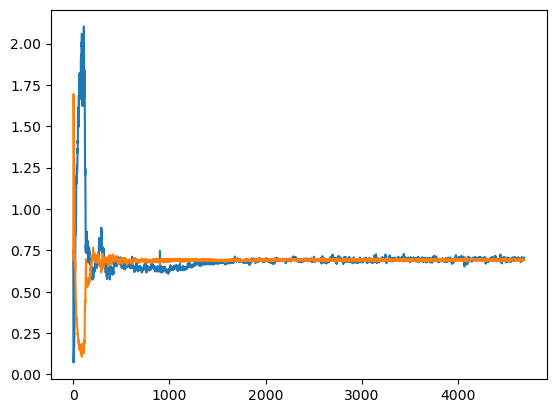

In [20]:
with open(f'{save_dir}/log_dict.json', 'r') as f:
    log_dict = json.load(f)
plt.plot(log_dict['train_generator_loss_per_batch'])
plt.plot(log_dict['train_discriminator_loss_per_batch'])

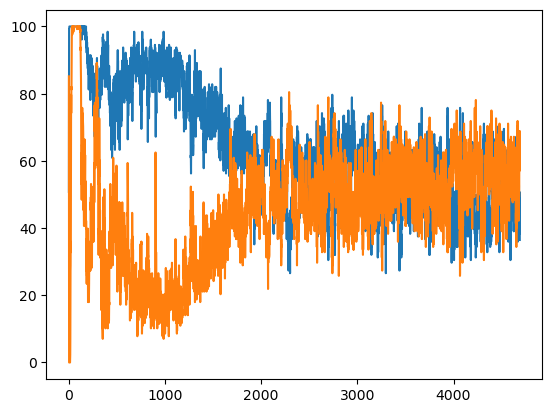

In [21]:
plt.plot(log_dict['train_discriminator_real_acc_per_batch'])
plt.plot(log_dict['train_discriminator_fake_acc_per_batch'])